In [1]:
import numpy as np
import pickle
import os
import re
import pandas as pd
import tqdm
import glob

import sys
sys.path.append("../../scripts")

import matplotlib.pyplot as plt

from scripts.run_bubblewrap import BubblewrapRun

In [2]:
files = glob.glob("*pickle")
files.sort()
files[-2:]

['bubblewrap_run_2023-04-27-15-25-37.pickle',
 'bubblewrap_run_2023-04-27-15-32-54.pickle']

In [3]:
file = 'bubblewrap_run_2023-04-27-10-34-20.pickle'
file

'bubblewrap_run_2023-04-27-10-34-20.pickle'

In [4]:
with open(file, "rb") as fhan:
    br = pickle.load(fhan)
    if br.bw_parameters and "seed" not in br.bw_parameters:
        br.bw_parameters["seed"] = 42

FileNotFoundError: [Errno 2] No such file or directory: 'bubblewrap_run_2023-04-27-10-34-20.pickle'

In [ ]:
for key, value in br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {br.file}")
print(f"savefile: {br.outfile}")

In [5]:
plt.plot(np.linalg.norm(br.A_list - br.A_list[-1], axis=(1,2)))

NameError: name 'br' is not defined

In [ ]:
plt.plot(br.bw_parameters["lookahead_steps"], pp_means)

# Comparing new and old forcasting metrics

In [62]:
# old_way_file = 'bubblewrap_run_2023-04-27-11-48-30.pickle'
# new_way_file = 'bubblewrap_run_2023-04-27-11-49-13.pickle'
# dataset = 'clock fast'

# old_way_file = 'bubblewrap_run_2023-04-27-11-50-01.pickle'
# new_way_file = 'bubblewrap_run_2023-04-27-11-50-47.pickle'
# dataset = 'clock slow'

# old_way_file = "bubblewrap_run_2023-04-27-11-39-10.pickle"
# new_way_file = "bubblewrap_run_2023-04-27-11-39-52.pickle"
# dataset = "halfspeed"


# old_way_file = "bubblewrap_run_2023-04-27-11-40-41.pickle"
# new_way_file = "bubblewrap_run_2023-04-27-11-41-28.pickle"
# dataset = "shuffled"

# old_way_file = "bubblewrap_run_2023-04-27-11-41-57.pickle"
# new_way_file = "bubblewrap_run_2023-04-27-11-42-12.pickle"
# dataset = "monkey reach"

# old_way_file = 'bubblewrap_run_2023-04-27-12-22-38.pickle'
# new_way_file = 'bubblewrap_run_2023-04-27-12-22-44.pickle'
# dataset = 'neuropixel'

# old_way_file = 'bubblewrap_run_2023-04-27-12-23-43.pickle'
# new_way_file = 'bubblewrap_run_2023-04-27-12-24-36.pickle'
# dataset = 'mouse'

# old_way_file = 'bubblewrap_run_2023-04-27-12-25-31.pickle'
# new_way_file = 'bubblewrap_run_2023-04-27-12-26-25.pickle'
# dataset = 'widefield'


##################################
# note: these don't have `A` saved

# old_way_file = 'bubblewrap_run_2023-04-27-14-55-21.pickle'
# new_way_file = 'bubblewrap_run_2023-04-27-15-01-37.pickle'
# dataset = 'neuropixel'

# old_way_file = 'bubblewrap_run_2023-04-27-15-09-55.pickle'
# new_way_file = 'bubblewrap_run_2023-04-27-15-18-06.pickle'
# dataset = 'mouse'

old_way_file = 'bubblewrap_run_2023-04-27-15-25-37.pickle'
new_way_file = 'bubblewrap_run_2023-04-27-15-32-54.pickle'
dataset = 'widefield'


with open(new_way_file, "rb") as fhan:
    new_way_br = pickle.load(fhan)

with open(old_way_file, "rb") as fhan:
    old_way_br = pickle.load(fhan)

In [63]:
for key, value in new_way_br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {new_way_br.file}")
print(f"savefile: {new_way_br.outfile}")

num: 200
lam: 0.001
nu: 0.001
eps: 0.001
step: 0.08
M: 30
B_thresh: -10
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 32, 35, 40, 50, 64, 80, 100, 128, 256, 512]
seed: 42
save_A: False
input file: ./generated/widefield_reduced.npy
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-04-27-15-32-54.pickle


Text(0.5, 1.0, '$A$ convergence over time (mouse)')

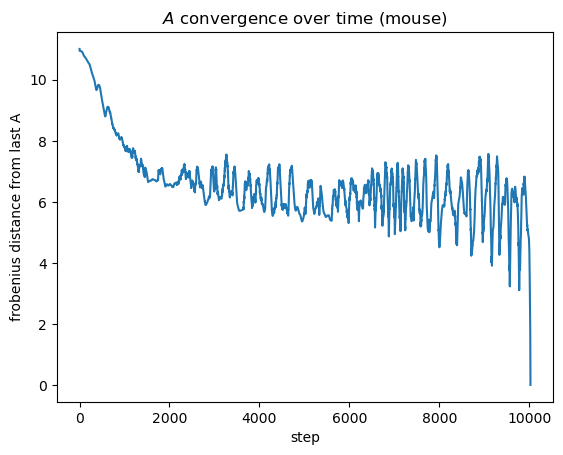

In [18]:
%matplotlib inline
plt.plot(np.linalg.norm(new_way_br.A_list - new_way_br.A_list[-1], axis=(1,2)))
plt.xlabel("step")
plt.ylabel("frobenius distance from last A")
plt.title(f"$A$ convergence over time ({dataset})")

In [19]:
AA = new_way_br.A_list
A_differences = np.zeros((AA.shape[0], AA.shape[0]))
for i in tqdm.tqdm(range(AA.shape[0])):
    for j in range(AA.shape[0]):
        A_differences[i,j] = np.linalg.norm(AA[i] - AA[j])
        A_differences[j,i] = A_differences[i,j]


100%|█████████████████████████████████████| 10030/10030 [41:07<00:00,  4.07it/s]


In [20]:
%matplotlib inline
plt.imshow((A_differences))
plt.title(f"pairwise differences between A's ({dataset})")
plt.xlabel("step")
plt.ylabel("step")

plt.colorbar();

In [23]:
AA = new_way_br.A_list
AAH = np.array([np.power(a,100) for a in AA])

Ah_differences = np.zeros((AA.shape[0], AA.shape[0]))
for i in tqdm.tqdm(range(AA.shape[0])):
    for j in range(AA.shape[0]):
        if abs(i-j) < 1000:
            Ah_differences[i,j] = np.linalg.norm(AAH[i] - AAH[j])
            Ah_differences[j,i] = Ah_differences[i,j]


100%|█████████████████████████████████████| 10030/10030 [08:49<00:00, 18.94it/s]


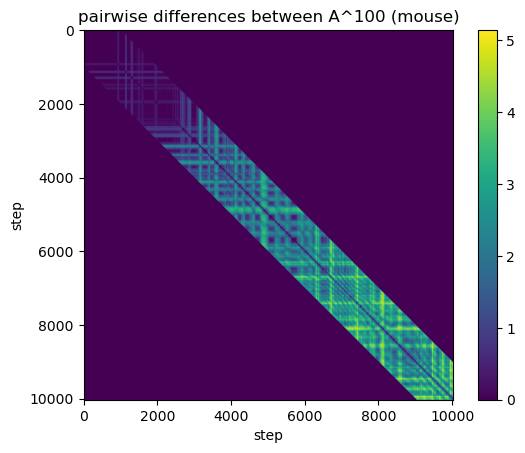

In [24]:
%matplotlib inline
plt.imshow((Ah_differences))
plt.title(f"pairwise differences between A^100 ({dataset})")
plt.xlabel("step")
plt.ylabel("step")

plt.colorbar();

Text(0.5, 1.0, 'Estimated $A$ convergence speed to A^100 (mouse)')

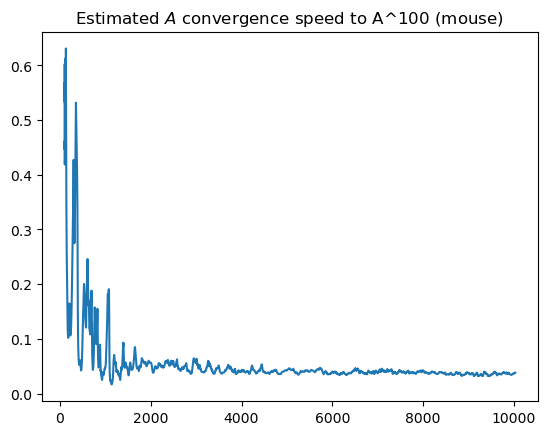

In [25]:
%matplotlib inline
def get_slope(a):
    power = 20
    a_final = np.linalg.matrix_power(a, 100)
    current = a
    distances = []
    for _ in range(power+1):
        distances.append(np.linalg.norm(current - a_final))
        current = current @ a
    d = np.diff(np.log(distances))
    
    
    return d[10:].mean()

plt.figure()
slopes = []
end = AA.shape[0]
start = 100
for i in range(start,end):
    slopes.append(get_slope(AA[i]))
slopes = np.array(slopes)
plt.plot(np.arange(start,end),-slopes)
plt.title(f"Estimated $A$ convergence speed to A^100 ({dataset})")

Text(0, 0.5, 'eigenvalue')

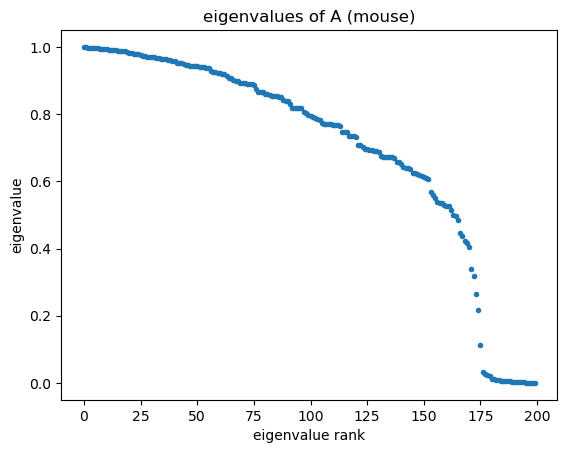

In [26]:
s = np.sort(np.abs(np.linalg.eigvals(old_way_br.A)))[::-1]
plt.plot(s,'.')
plt.title(f"eigenvalues of A ({dataset})")
plt.xlabel("eigenvalue rank")
plt.ylabel("eigenvalue")

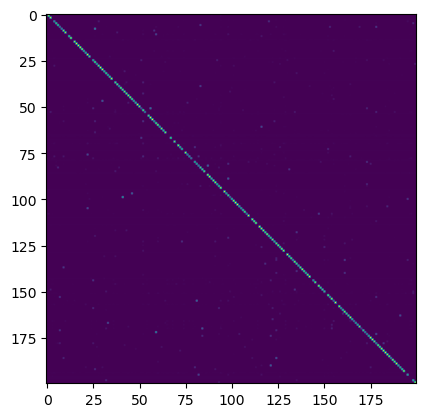

In [27]:
%matplotlib inline
plt.imshow(new_way_br.A)

In [64]:
assert new_way_br.bw_parameters.items() == old_way_br.bw_parameters.items()
assert np.all(new_way_br.entropy_list == old_way_br.entropy_list)
assert np.all((new_way_br.pred_list == old_way_br.pred_list)[:,0])
assert new_way_br.bw_parameters["lookahead_steps"] == old_way_br.bw_parameters["lookahead_steps"]
print((new_way_br.pred_list == old_way_br.pred_list)[:,1:].mean())

1.3337449830194504e-05


In [65]:
if "clock" in new_way_br.file:
    states = np.load("../../"+new_way_br.file)["x"]
else:
    states = None

In [66]:
T = new_way_br.pred_list.shape[0]
new_way_means = []
old_way_means = []

new_way_stds = []
old_way_stds = []
for i, step in enumerate(new_way_br.bw_parameters["lookahead_steps"]):
    first_nonzero = np.nonzero(np.isnan(new_way_br.pred_list[:,i]))[0]
    if len(first_nonzero):
        local_T = first_nonzero[0]
    else:
        local_T = T
    new_way_means.append(np.mean(new_way_br.pred_list[-local_T//2:local_T,i]))
    new_way_stds.append(np.std(new_way_br.pred_list[-local_T//2:local_T,i], ddof=1))
    # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")

for i, step in enumerate(old_way_br.bw_parameters["lookahead_steps"]):
    old_way_means.append(np.mean(old_way_br.pred_list[-T//2:,i]))
    old_way_stds.append(np.std(old_way_br.pred_list[-T//2:,i], ddof=1))
    # print(f"old way {step:>2} step(s) ahead mean: {old_way_means[-1]}")
new_way_means = np.array(new_way_means)
old_way_means = np.array(old_way_means)
new_way_stds = np.array(new_way_stds)
old_way_stds = np.array(old_way_stds)

In [67]:
%matplotlib qt
plt.figure()
plt.errorbar(new_way_br.bw_parameters["lookahead_steps"], new_way_means, new_way_stds/np.sqrt(T/2))
plt.errorbar(new_way_br.bw_parameters["lookahead_steps"], old_way_means, old_way_stds/np.sqrt(T/2),)
plt.fill_between(new_way_br.bw_parameters["lookahead_steps"], new_way_means - new_way_stds,new_way_means+ new_way_stds, color="C0", alpha=0.2)
plt.fill_between(new_way_br.bw_parameters["lookahead_steps"], old_way_means - old_way_stds,old_way_means+ old_way_stds, color="C1", alpha=0.2)
plt.legend(["new $\pm$ std", "old $\pm$ std","new $\pm$ sem", "old $\pm$ sem"])
plt.ylabel("mean log pred. p. for last half")
plt.xlabel("number of steps ahead predicted")
plt.title(f"{dataset}")

Text(0.5, 1.0, 'widefield')

In [68]:
%matplotlib qt

fig, axs = plt.subplots(2,1, sharex=True)
steps = [1,4,8,16,256]
for si, step in enumerate(steps):
    i = new_way_br.bw_parameters["lookahead_steps"].index(step)
    old_pred = old_way_br.pred_list[:,i]
    new_pred = new_way_br.pred_list[:,i]
    # plt.plot(pred)
    half_width = 75
    kernel = np.linspace(0,10,half_width)
    kernel = np.exp(kernel)
    kernel = np.hstack((kernel, np.flip(kernel)))
    kernel = kernel/kernel.sum()
    smoothed_old_pred = np.convolve(old_pred, kernel, 'valid')
    smoothed_new_pred = np.convolve(new_pred, kernel, 'valid')
    axs[0].plot(np.arange(smoothed_old_pred.size) + half_width,smoothed_old_pred, color=f'C{si}', linestyle='dashed')
    x_correction = (step-1)*1
    axs[0].plot(np.arange(smoothed_new_pred.size) + half_width + x_correction,smoothed_new_pred, color=f'C{si}',linestyle='solid')

legend = []
for step in steps:
    legend.append(f"old {step} step")
    legend.append(f"new {step} step")
axs[0].legend(legend)
axs[0].set_title(f"{dataset} smoothed prediction")
axs[0].set_xlabel("timestep")
axs[0].set_ylabel("log pred. prob.");

if states is not None:
    axs[1].plot(states,'.')
else:
    alpha = new_way_br.alpha_list.T
    state_means = alpha.mean(axis=1)
    alpha = alpha[state_means > np.quantile(state_means, .75),:]
    alpha = alpha[np.argsort(-alpha.mean(axis=1)) - (alpha.shape[0]//2),:]
    axs[1].imshow((alpha), aspect="auto", interpolation="nearest")
# axs[0].set_xlim([500, 1000])

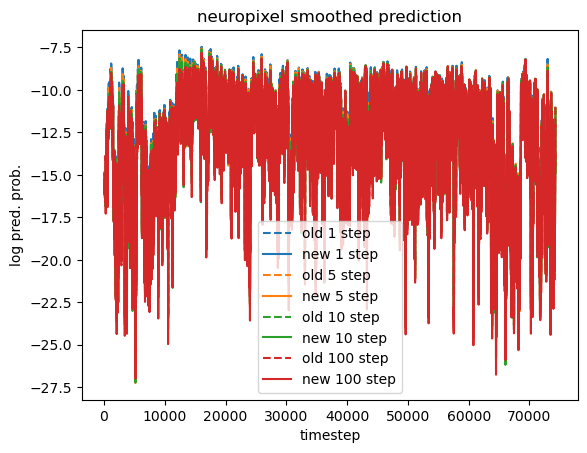

In [50]:
%matplotlib inline
steps = [1,5,10, 100]
# steps = [1,64, 512, 1024]
for si, step in enumerate(steps):
    i = new_way_br.bw_parameters["lookahead_steps"].index(step)
    old_pred = old_way_br.pred_list[:,i]
    new_pred = new_way_br.pred_list[:,i]
    # plt.plot(pred)
    half_width = 75
    kernel = np.linspace(0,10,half_width)
    kernel = np.exp(kernel)
    kernel = np.hstack((kernel, np.flip(kernel)))
    kernel = kernel/kernel.sum()
    smoothed_old_pred = np.convolve(old_pred, kernel, 'valid')
    smoothed_new_pred = np.convolve(new_pred, kernel, 'valid')
    plt.plot(np.arange(smoothed_old_pred.size) + half_width,smoothed_old_pred, color=f'C{si}', linestyle='dashed')
    plt.plot(np.arange(smoothed_new_pred.size) + half_width +step-1 ,smoothed_new_pred, color=f'C{si}',linestyle='solid')

legend = []
for step in steps:
    legend.append(f"old {step} step")
    legend.append(f"new {step} step")
plt.legend(legend)
plt.title(f"{dataset} smoothed prediction")
plt.xlabel("timestep")
plt.ylabel("log pred. prob.");

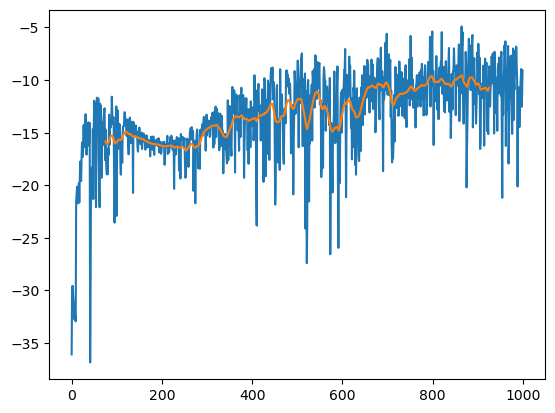

In [53]:
i = new_way_br.bw_parameters["lookahead_steps"].index(1)
pred = new_way_br.pred_list[:1000,i]
plt.plot(pred)
half_width = 75
kernel = np.linspace(0,10,half_width)
kernel = np.exp(kernel)
kernel = np.hstack((kernel, np.flip(kernel)))
kernel = kernel/kernel.sum()
smoothed_pred = np.convolve(pred, kernel, 'valid')
plt.plot(np.arange(smoothed_pred.size) + half_width,smoothed_pred)

In [345]:
np.abs(s).shape

(200,)

In [392]:
%matplotlib qt


biggest_state = alpha[np.argmax(alpha.mean(axis=1)),:]
biggest_state -= biggest_state.min()
biggest_state /= biggest_state.max()
biggest_state = np.convolve(biggest_state, kernel, 'valid')
plt.plot(biggest_state)

pred = old_way_br.pred_list[:,0]
pred -= pred.min()
pred /= pred.max()
pred = np.convolve(pred, kernel, 'valid')
plt.plot(pred)

In [393]:
np.corrcoef(biggest_state[biggest_state.shape[0]//2:], pred[pred.shape[0]//2:])[0,1]

0.13815930359196402

# Old analysis

In [ ]:
run_files = []

for file in os.listdir():
    if os.path.isfile(file) and re.search("bubblewrap_run_.*\.pickle",file):
        run_files.append(file)

In [ ]:
runs = []
for file in run_files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
        if br.bw_parameters and "seed" not in br.bw_parameters:
            br.bw_parameters["seed"] = 42
        runs.append(br)

In [ ]:
# num, lam, nu, eps, B_thresh
columns = {}

for param in ["num", "nu", "lam", "eps", "B_thresh", "seed"]:
    columns[param] = [runs[x].bw_parameters[param] for x in range(len(runs))]


columns["ent1"] = [runs[x].entropy_list[-100:,0].mean() for x in range(len(runs))]
columns["ent10"] = [runs[x].entropy_list[-100:,1].mean() for x in range(len(runs))]
columns["pred1"] = [runs[x].pred_list[-100:,0].mean() for x in range(len(runs))]
columns["pred10"] = [runs[x].pred_list[-100:,1].mean() for x in range(len(runs))]
columns["time"] = [runs[x].time_to_run if hasattr(runs[x], "time_to_run") else None for x in range(len(runs))]

columns["file"] = [runs[x].file for x in range(len(runs))]
columns["run"] = runs
columns["location"] = run_files
fdf = pd.DataFrame(columns)

In [ ]:
unique_files = fdf.file.unique()
unique_files

array(['./generated/lorenz_1trajectories_3dim_500to20500_noise0.05.npz',
       './generated/vdp_1trajectories_2dim_500to20500_noise0.2.npz',
       './generated/lorenz_1trajectories_3dim_500to20500_noise0.2.npz',
       './generated/vdp_1trajectories_2dim_500to20500_noise0.05.npz',
       'generated/vdp_100trajectories_2dim_500to20500_noise0.2.npz',
       'generated/vdp_1trajectories_2dim_500to20500_noise0.2.npz'],
      dtype=object)

In [ ]:
df = fdf[fdf.file == unique_files[0]]

In [ ]:
correlations = df.corr(numeric_only=True)
params = ["num", "nu", "lam", "eps", "B_thresh"]
metrics = ["ent1","ent10","pred1","pred10", "time"]
param_comparison = correlations.loc[params, metrics]
param_comparison

,ent1,ent10,pred1,pred10,time
num,0.479419,0.820371,0.614206,-0.111629,0.949386
nu,-0.000744,0.014677,0.024215,0.046374,0.041001
lam,-0.048973,-0.047700,-0.018634,-0.062965,-0.055963
eps,0.573448,0.291129,-0.523616,-0.610617,0.022681
B_thresh,0.380212,0.257026,-0.019321,-0.202639,0.230475


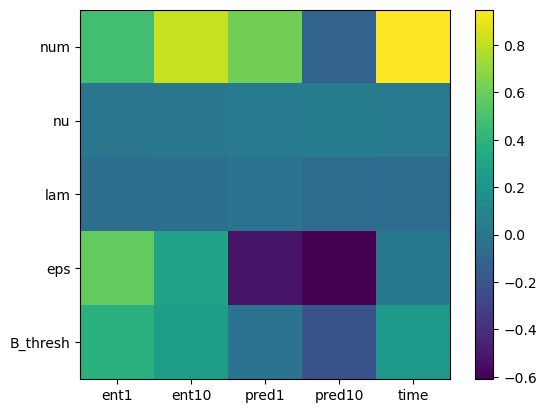

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(param_comparison)
#np.convolve(np.arange(len(metrics)+1), [.5, .5])
ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)

ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels(params)

fig.colorbar(im)

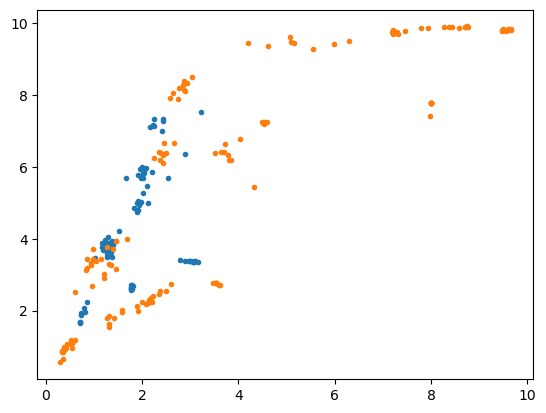

In [ ]:
mask = df.eps == .0001
a = df.ent1
b = df.ent10
plt.plot(a[mask], b[mask], '.')
plt.plot(a[~mask], b[~mask], '.')

In [ ]:
df

,num,nu,lam,eps,B_thresh,seed,ent1,ent10,pred1,pred10,time,file,run,location
0,1024,0.0010,0.0010,0.0001,-5,42,2.154670,7.117517,-6.093047,-12.112070,46.776133,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-04-23-19-59.pickle
2,16,0.0010,0.0010,0.0001,-15,42,0.822588,1.974006,-10.159780,-10.493128,16.526105,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-08-25-50.pickle
6,1024,0.0010,0.0001,0.0010,-10,42,2.867526,8.383525,-6.963832,-11.433135,41.378214,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-04-23-03-42.pickle
10,16,0.0010,0.0010,0.0010,-15,42,0.361579,0.840695,-10.937058,-11.063611,16.207495,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-04-23-21-43.pickle
11,1024,0.0001,0.0010,0.0010,-5,42,6.305058,9.517545,-7.644871,-11.500990,48.316343,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-10-02-16.pickle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,1024,0.0100,0.0001,0.0100,-10,42,8.741961,9.911880,-9.288745,-12.022569,42.979244,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-05-41-50.pickle
849,16,0.0100,0.0100,0.0001,-15,42,0.726606,1.871307,-10.216708,-10.486780,16.536573,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-06-59-11.pickle
850,16,0.0010,0.0001,0.0010,-15,390,0.364190,0.890838,-11.000175,-11.104077,16.223406,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-12-04-26.pickle
853,1024,0.0001,0.0100,0.0001,-5,580,2.432374,7.277180,-6.242277,-12.084297,46.838399,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-12-29-18.pickle


In [ ]:
for file in df.loc[df.iloc[:,:-2].duplicated(),"location"]:
    print(f"mv {file} duplicates")